# A notebook to explore the newly migrated DVC data.

We've added weather data (temp and cloud cover) to the chunked DVC data warehouse. Doing basic exploring here 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from prefect import flow 
from IPython.core.debugger import set_trace

In [18]:
# Auto reload core modules so I don't need to restart kernel when I change
# the code in those modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from core.consts import EIA_TEST_SET_HOURS, EIA_BUFFER_HOURS
from core.model import get_data_for_model_input
from core.data import get_chunk_index, get_range_from_dvc_as_df, clean_data, fetch_data

In [20]:
# Lets fetch the DVC chunks directly
dvc_df = get_range_from_dvc_as_df(
    pd.Timestamp('2015-07-01 05:00:00+00:00'), 
    pd.Timestamp('2024-11-15 16:00:00+00:00')
)

Requesting data from DVC. start:2015-07-01 05:00:00+00:00. end:2024-11-15 16:00:00+00:00
DVC git repo is clean


/app/core/data.py:147: UserWarning: Converting to Period representation will drop timezone information.
  q_start_ts = pd.Timestamp(start_ts).to_period('Q').start_time.tz_localize('UTC')
/app/core/data.py:148: UserWarning: Converting to Period representation will drop timezone information.
  q_end_ts = pd.Timestamp(end_ts).to_period('Q').end_time.tz_localize('UTC')
/usr/local/lib/python3.10/site-packages/dulwich/repo.py:886: DeprecationWarning: use get_user_identity() rather than Repo._get_user_identity
  warnings.warn(


Fetched data from DVC. start:2015-07-01 05:00:00+00:00. end:2024-11-15 16:00:00+00:00


In [21]:
dvc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82212 entries, 2015-07-01 05:00:00+00:00 to 2024-11-15 16:00:00+00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   D               82041 non-null  float64
 1   temperature_2m  82212 non-null  float64
 2   cloud_cover     82212 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 4.5 MB


<Axes: xlabel='utc_ts'>

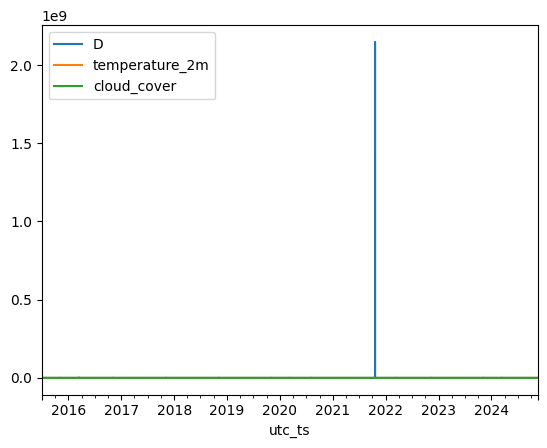

In [29]:
# Looks like there's a big outlier in the demand data in 2021.
dvc_df.plot()

In [31]:
# Let's preprocess the demand timeseries for easier viewing
dvc_df = clean_data(dvc_df)

Input data skew: 203.77536171350715
Output data skew: 0.8340904021977523
Null demand values: 171


<Axes: xlabel='utc_ts'>

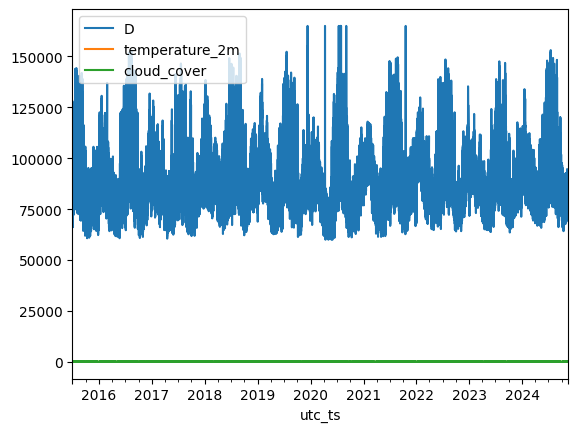

In [32]:
dvc_df.plot()

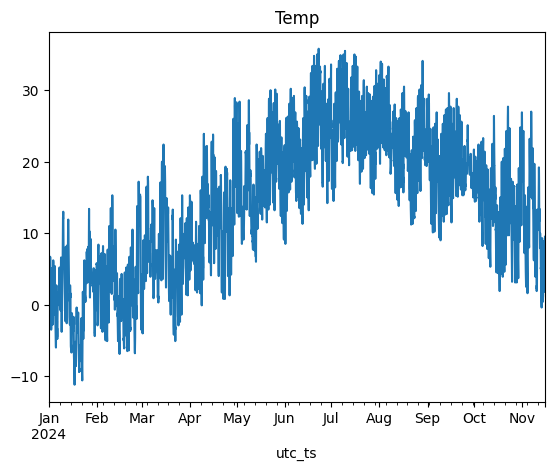

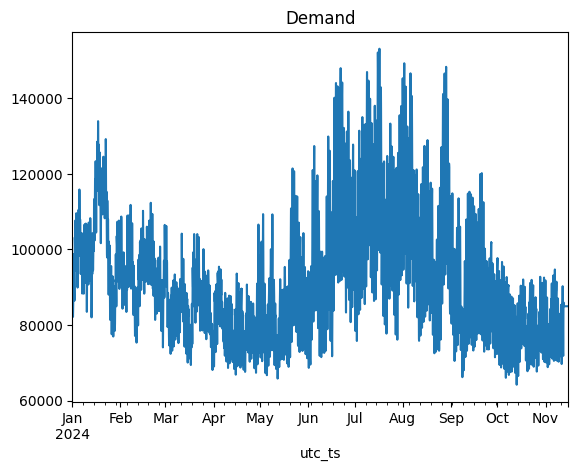

In [43]:
dvc_df_recent = dvc_df[dvc_df.index >= '2024']
dvc_df_recent.temperature_2m.plot(title='Temp')
plt.show()
dvc_df_recent.D.plot(title='Demand')
plt.show()

# Is there a relationship between the weather and power demand?
Yes - and there's an intuitive bifurcation where buildings switch between heating and cooling. In the heating case, as the outside gets colder more power is consumed. In the cooling case, as the outside gets hotter more power is consumed.

Because of this bifurcation, a single covariance scalar wouldn't capture the relationship well.

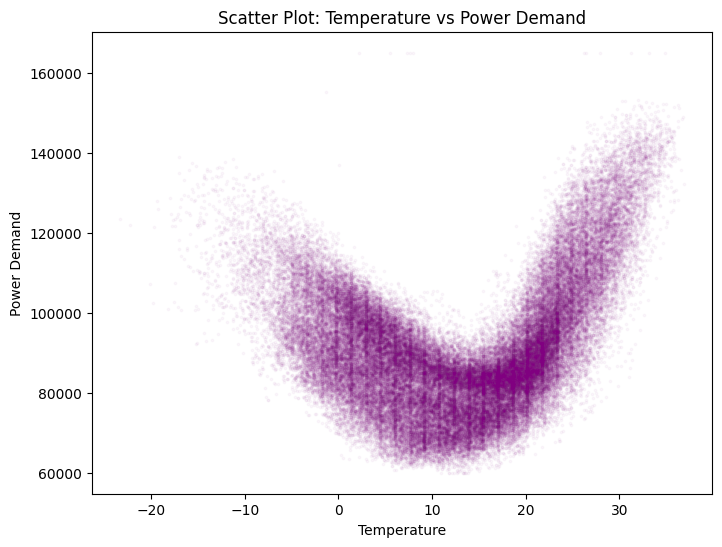

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(dvc_df['temperature_2m'], dvc_df['D'], color='purple', alpha=0.03, s=3)
plt.xlabel('Temperature')
plt.ylabel('Power Demand')
plt.title('Scatter Plot: Temperature vs Power Demand')
plt.show()